# Regression showdown

In [1]:
import jax
import jax.numpy as jnp
import flax.linen as nn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from functools import partial
from typing import Callable
from tqdm.notebook import tqdm
from itertools import product
from rebayes.utils import datasets
from jax.flatten_util import ravel_pytree

from rebayes import base
from rebayes.extended_kalman_filter import ekf
from rebayes.low_rank_filter import lofi

In [2]:
import hparam_tune_ekf as hp_ekf
import hparam_tune_lofi as hp_lofi

In [3]:
%config InlineBackend.figure_format = "retina"
%load_ext autoreload
%autoreload 2

In [4]:
plt.rcParams["font.size"] = 12
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["legend.fontsize"] = 12
plt.rcParams["lines.linewidth"] = 2

In [6]:
# dataset = "wine"
# train, test = datasets.load_uci_wine_regression()

# dataset = "power"
# train, test = datasets.load_uci_power()

# dataset = "kin8nm"
# train, test = datasets.load_uci_kin8nm()

# dataset = "naval"
# train, test = datasets.load_uci_naval()

dataset = "rmnist_2"
train, test = datasets.load_rotated_mnist(frac_train=0.8, num_train=None, target_digit=[0,1,2,3,4], sort_by_angle=False)

In [7]:
# train, test = datasets.load_1d_synthetic_dataset(5_000, 1_000, sort_data=False)
(X_train, y_train) = train
(X_test, y_test) = test

y_train = y_train.ravel()
y_test = y_test.ravel()

In [8]:
def rmae_callback(bel, *args, **kwargs):
    X_test, y_test = kwargs["X_test"], kwargs["y_test"]
    apply_fn = kwargs["apply_fn"]
    
    yhat = apply_fn(bel.mean, X_test).squeeze()
    err = jnp.abs(y_test - yhat.ravel())
    
    res = {
        "test": err.mean(),
    }
    return res

In [9]:
def eval_callback(bel, pred, t, X, y, **kwargs):
    X_test, y_test = kwargs["X_test"], kwargs["y_test"]
    apply_fn = kwargs["apply_fn"]
    
    yhat = apply_fn(bel.mean, X_test).squeeze()
    err_test = jnp.abs(y_test - yhat.ravel())
    
    # One-step-ahead absolute error
    err = jnp.abs(y.ravel() - pred.mean.ravel()).sum()
    
    
    res = {
        "test": err_test.mean(),
        "osa-error": err,
    }
    return res

## Test setup

In [10]:
key = jax.random.PRNGKey(3141)

In [11]:
n_warmup = 1000

X_warmup = X_train[:n_warmup]
y_warmup = y_train[:n_warmup]

X_learn = X_train[n_warmup:]
y_learn = y_train[n_warmup:]

warmup_train = (X_warmup[:-100], y_warmup[:-100])
warmup_test = (X_warmup[-100:], y_warmup[-100:])

```
dynamics_weights: gamma
init_cov: eta
emission_cov: r
dynamics_cov: q (steady-state assumption)
```

In [12]:
pbounds = {
    "log_init_cov": (-5, 0.0),
    "dynamics_weights": (0, 1.0),
    "log_emission_cov": (-7, 0.0),
}

pbounds_adapted = pbounds.copy()
pbounds_adapted.pop("log_emission_cov");

In [13]:
dynamics_weights = [0.0, 0.5, 1.0] # gamma
log_init_cov = np.log([0.01, 0.1, 1.0]) # eta
log_emission_cov = np.log([0.01, 0.1, 1.0]) # R

elements = product(dynamics_weights, log_init_cov, log_emission_cov)
probe_points = [{
    "dynamics_weights": gamma,
    "log_init_cov": log_eta,
    "log_emission_cov": log_R 
} for gamma, log_eta, log_R in elements]


elements = product(dynamics_weights, log_init_cov)
probe_points_adapted = [{
    "dynamics_weights": gamma,
    "log_init_cov": log_eta
} for gamma, log_eta in elements]


probe_points = []
n_init_points = 0 if len(probe_points) > 0 else 10

## Model setup

In [14]:
class MLP(nn.Module):
    n_out: int
    activation: Callable = nn.relu
    
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(20)(x)
        x = self.activation(x)
        x = nn.Dense(20)(x)
        x = self.activation(x)
        x = nn.Dense(self.n_out)(x)
        return x
    
dim_out = 1
_, dim_in = X_train.shape
model = MLP(dim_out, activation=nn.elu)

In [15]:
params = model.init(key, jnp.ones((1, dim_in)))
flat_params, _ = ravel_pytree(params)
n_params = len(flat_params)

# Agent showdown

## Diag-EKF

In [16]:
optimizer, apply_fn, n_feats = hp_ekf.create_optimizer(
    model, pbounds, 314, warmup_train, warmup_test, rmae_callback
)

In [17]:
%%time
# Probe points
for ppoint in probe_points:
    optimizer.probe(ppoint, lazy=True)

optimizer.maximize(
    init_points=n_init_points,
    n_iter=10,
)

|   iter    |  target   | dynami... | log_em... | log_in... |
-------------------------------------------------------------
| 1         | -0.9206   | 0.9169    | -2.88     | -3.675    |
| 2         | -0.9202   | 0.7832    | -0.574    | -0.8632   |
| 3         | -0.922    | 0.728     | -5.177    | -0.4412   |
| 4         | -0.9171   | 0.2608    | -1.635    | -3.692    |
| 5         | -0.9217   | 0.1223    | -4.298    | -0.7996   |
| 6         | -0.9219   | 0.2782    | -6.511    | -1.834    |
| 7         | -0.9205   | 0.5848    | -2.931    | -1.614    |
| 8         | -0.9201   | 0.6872    | -3.928    | -3.395    |
| 9         | -0.9216   | 0.5706    | -3.641    | -0.6946   |
| 10        | -0.8923   | 0.8348    | -6.26     | -4.698    |
| 11        | -0.9209   | 0.07327   | -7.0      | -5.0      |
| 12        | -0.8727   | 0.9126    | -6.189    | -4.531    |
| 13        | -0.9195   | 0.3586    | -0.7124   | -0.1941   |
| 14        | -0.5053   | 0.9985    | -6.077    | -4.561    |
| 15    

In [18]:
test_kwargs = {"X_test": X_test, "y_test": y_test, "apply_fn": apply_fn}

hparams = hp_ekf.get_best_params(n_params, optimizer, method="fdekf")
fd_ekf_estimator = hp_ekf.build_estimator(flat_params, hparams, None, apply_fn, method="fdekf")
bel_fd_ekf, output_fd_ekf = fd_ekf_estimator.scan(
    X_learn, y_learn, callback=eval_callback, progress_bar=False, **test_kwargs
)

## LoFi (orth / fixed)

In [19]:
method = "orth_svd_lofi"
params_lofi = lofi.LoFiParams(
    memory_size=50,
    sv_threshold=0.0,
    adaptive_variance=False,
)

optimizer, apply_fn, n_features = hp_lofi.create_optimizer(
    model, pbounds, 314, warmup_train, warmup_test, params_lofi, rmae_callback, method=method
)

In [20]:
%%time
# Probe points
for ppoint in probe_points:
    optimizer.probe(ppoint, lazy=True)

optimizer.maximize(
    init_points=n_init_points,
    n_iter=10,
)

|   iter    |  target   | dynami... | log_em... | log_in... |
-------------------------------------------------------------
| 1         | -0.8367   | 0.9169    | -2.88     | -3.675    |
| 2         | -0.922    | 0.7832    | -0.574    | -0.8632   |
| 3         | -10.0     | 0.728     | -5.177    | -0.4412   |
| 4         | -0.9171   | 0.2608    | -1.635    | -3.692    |
| 5         | -0.9217   | 0.1223    | -4.298    | -0.7996   |
| 6         | -0.9219   | 0.2782    | -6.511    | -1.834    |
| 7         | -0.9206   | 0.5848    | -2.931    | -1.614    |
| 8         | -0.9207   | 0.6872    | -3.928    | -3.395    |
| 9         | -0.9217   | 0.5706    | -3.641    | -0.6946   |
| 10        | -0.9297   | 0.8348    | -6.26     | -4.698    |
| 11        | -0.9252   | 0.8541    | -6.294    | -4.674    |
| 12        | -0.921    | 0.0       | -3.918    | -1.796    |
| 13        | -0.9182   | 0.0       | -2.724    | -2.828    |
| 14        | -0.9188   | 0.8208    | -1.523    | -2.278    |
| 15    

In [21]:
test_kwargs = {"X_test": X_test, "y_test": y_test, "apply_fn": apply_fn}

hparams = hp_lofi.get_best_params(n_params, optimizer)
lofi_of_estimator = hp_lofi.build_estimator(flat_params, hparams, params_lofi, apply_fn, method=method)
bel_lofi_of, output_lofi_of = lofi_of_estimator.scan(
    X_learn, y_learn, callback=eval_callback, progress_bar=False, **test_kwargs
)

## LoFi (full / fixed)

In [22]:
method = "full_svd_lofi"
params_lofi = lofi.LoFiParams(
    memory_size=50,
    sv_threshold=0.0,
    adaptive_variance=False
)

optimizer, apply_fn, n_features = hp_lofi.create_optimizer(
    model, pbounds, 314, warmup_train, warmup_test, params_lofi, rmae_callback, method=method
)

In [23]:
%%time
# Probe points
for ppoint in probe_points:
    optimizer.probe(ppoint, lazy=True)

optimizer.maximize(
    init_points=n_init_points,
    n_iter=10,
)

|   iter    |  target   | dynami... | log_em... | log_in... |
-------------------------------------------------------------
| 1         | -0.9206   | 0.9169    | -2.88     | -3.675    |
| 2         | -0.9202   | 0.7832    | -0.574    | -0.8632   |
| 3         | -0.9228   | 0.728     | -5.177    | -0.4412   |
| 4         | -0.9171   | 0.2608    | -1.635    | -3.692    |
| 5         | -0.9217   | 0.1223    | -4.298    | -0.7996   |
| 6         | -0.9219   | 0.2782    | -6.511    | -1.834    |
| 7         | -0.9205   | 0.5848    | -2.931    | -1.614    |
| 8         | -0.9201   | 0.6872    | -3.928    | -3.395    |
| 9         | -0.9216   | 0.5706    | -3.641    | -0.6946   |
| 10        | -0.9206   | 0.8348    | -6.26     | -4.698    |
| 11        | -0.9173   | 0.0       | -0.8376   | -3.534    |
| 12        | -0.9176   | 0.0       | -1.163    | -4.848    |
| 13        | -0.4618   | 1.0       | -0.5719   | -4.199    |
| 14        | -0.4568   | 1.0       | -0.4062   | -4.264    |
| 15    

In [24]:
test_kwargs = {"X_test": X_test, "y_test": y_test, "apply_fn": apply_fn}

hparams = hp_lofi.get_best_params(n_params, optimizer)
lofi_ff_estimator = hp_lofi.build_estimator(flat_params, hparams, params_lofi, apply_fn, method=method)
bel_lofi_ff, output_lofi_ff = lofi_ff_estimator.scan(
    X_learn, y_learn, callback=eval_callback, progress_bar=False, **test_kwargs
)

## ORFit

In [25]:
method = "orfit"
params_orfit = base.RebayesParams(
    initial_mean=flat_params,
    emission_mean_function=apply_fn,
    **hparams
)
orfit_estimator = lofi.RebayesLoFi(params_orfit, params_lofi, method=method)
bel_orfit, output_orfit = orfit_estimator.scan(
    X_learn, y_learn, callback=eval_callback, progress_bar=False, **test_kwargs
)

## FC-EKF

In [28]:
optimizer, apply_fn, n_features = hp_ekf.create_optimizer(
    model, pbounds, 314, warmup_train, warmup_test, rmae_callback, method="fcekf"
)

In [29]:
%%time
# Probe points
for ppoint in probe_points:
    optimizer.probe(ppoint, lazy=True)

optimizer.maximize(
    init_points=n_init_points,
    n_iter=10,
)

|   iter    |  target   | dynami... | log_em... | log_in... |
-------------------------------------------------------------
| 1         | -0.7627   | 0.9169    | -2.88     | -3.675    |
| 2         | -0.9233   | 0.7832    | -0.574    | -0.8632   |
| 3         | -0.9217   | 0.728     | -5.177    | -0.4412   |
| 4         | -0.9205   | 0.2608    | -1.635    | -3.692    |
| 5         | -0.9249   | 0.1223    | -4.298    | -0.7996   |
| 6         | -0.9252   | 0.2782    | -6.511    | -1.834    |
| 7         | -0.9237   | 0.5848    | -2.931    | -1.614    |
| 8         | -0.9232   | 0.6872    | -3.928    | -3.395    |
| 9         | -0.9248   | 0.5706    | -3.641    | -0.6946   |
| 10        | -0.9013   | 0.8348    | -6.26     | -4.698    |
| 11        | -0.924    | 0.8302    | -2.412    | -0.9887   |
| 12        | -0.2695   | 1.0       | -2.748    | -3.782    |
| 13        | -0.9226   | 0.3586    | -0.7124   | -0.1941   |
| 14        | -0.5752   | 0.9751    | -2.823    | -3.81     |
| 15    

In [30]:
test_kwargs = {"X_test": X_test, "y_test": y_test, "apply_fn": apply_fn}

hparams = hp_ekf.get_best_params(n_params, optimizer, method="fcekf")
fc_ekf_estimator = hp_ekf.build_estimator(flat_params, hparams, None, apply_fn, method="fcekf")
bel_fc_ekf, output_fc_ekf = fc_ekf_estimator.scan(
    X_learn, y_learn, callback=eval_callback, progress_bar=False, **test_kwargs
)

## Plot results

In [26]:
colors = {
    "lofi-of": "tab:blue",
    "lofi-oa": "tab:orange",
    "lofi-ff": "tab:red",
    "lofi-fa": "tab:pink",
    "orfit": "tab:green",
    "fd-ekf": "tab:purple",
    "fc-ekf": "tab:gray",
}

In [27]:
%%time
methods = {
    "lofi-of": output_lofi_of,
    # "lofi-oa": output_lofi_oa,
    "lofi-ff": output_lofi_ff,
    # "lofi-fa": output_lofi_fa,
    "orfit":   output_orfit,
    "fd-ekf": output_fd_ekf,
    # "fc-ekf": output_fc_ekf,
}

methods = jax.tree_map(np.array, methods)

CPU times: user 87.5 ms, sys: 57.1 ms, total: 145 ms
Wall time: 1min 13s


In [28]:
data = {
    key: methods[key]["test"]
    for key in methods
}

data = pd.DataFrame(data)

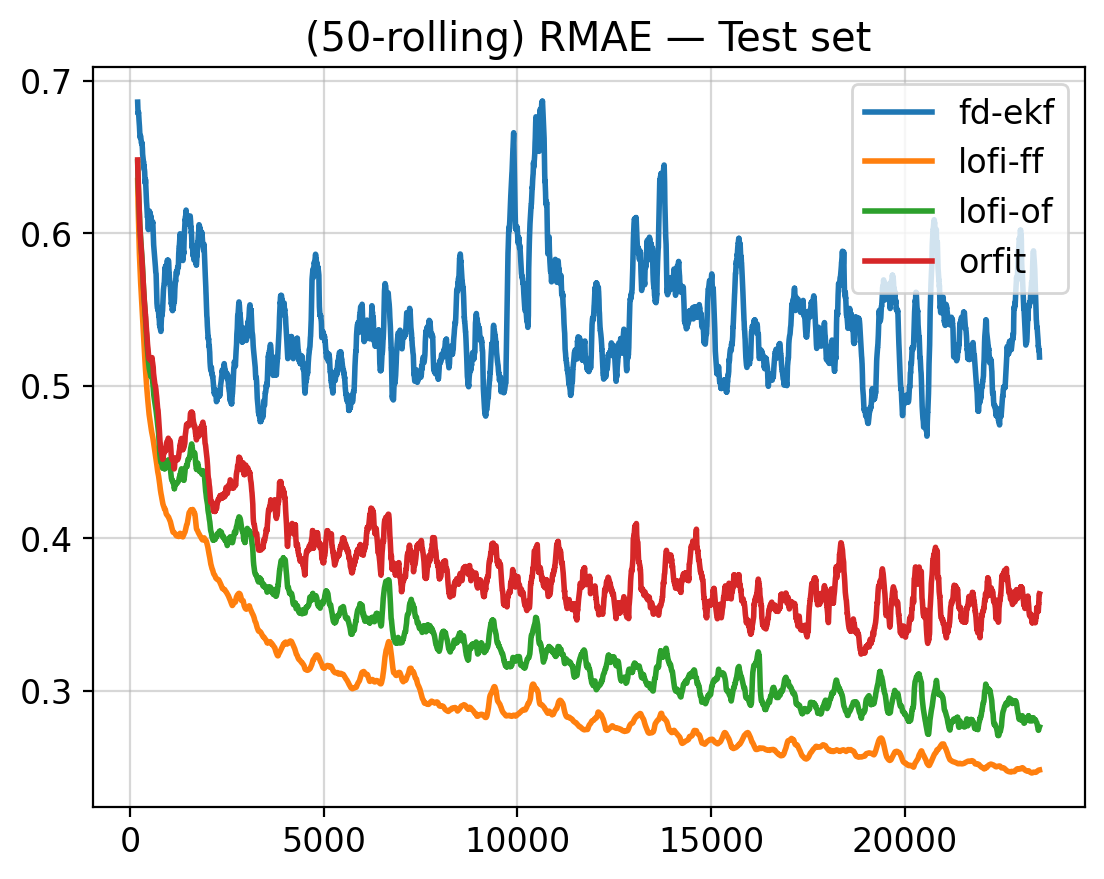

In [29]:
data.rolling(200).mean().plot()
plt.title(f"(50-rolling) RMAE — Test set")
plt.grid(alpha=0.5)

# Simulations

In [30]:
def eval_runs(key, num_runs_pc, estimator):
    num_devices = jax.device_count()
    num_sims = num_runs_pc * num_devices
    keys = jax.random.split(key, num_sims).reshape(-1, num_devices, 2)
    n_vals = len(X_learn)
    
    @partial(jax.pmap, in_axes=1)
    @partial(jax.vmap, in_axes=0)
    def evalf(key):
        key_shuffle, key_init = jax.random.split(key)
        ixs_shuffle = jax.random.choice(key, n_vals, (n_vals,), replace=False)
        
        params = model.init(key, jnp.ones((1, dim_in)))
        flat_params, _ = ravel_pytree(params)
        
        n_params = len(flat_params)

        bel, output = estimator.scan(
            X_learn[ixs_shuffle], y_learn[ixs_shuffle], callback=eval_callback, progress_bar=False, **test_kwargs
        )
        return output
    
    
    outputs = evalf(keys)
    outputs = jax.tree_map(lambda x: x.reshape(num_sims, -1), outputs)
    return outputs

In [31]:
def plot_sims(data, ax, color, label, rolling=100):
    data.mean(axis=1).rolling(rolling).mean().plot(ax=ax, label=label, color=color)
    sims = data.rolling(rolling).mean().values
    plt.plot(sims, c=color, alpha=0.07, linewidth=1)

In [32]:
def plot_bounds(data, ax, color, label, rolling=100):
    n_obs = len(data)
    xrange = np.arange(n_obs)
    data.mean(axis=1).rolling(rolling).mean().plot(ax=ax, label=label, color=color)
    
    sims = data.rolling(rolling).mean().values
    mean_sim = sims.mean(axis=1)
    std_sim = sims.std(axis=1)
    
    lbound = mean_sim - 2 * std_sim
    ubound = mean_sim + 2 * std_sim
    
    ax.fill_between(xrange, lbound, ubound, alpha=0.2, color=color)

## Run simulations

In [33]:
agents = {
    "lofi-of": lofi_of_estimator,
    # "lofi-oa": lofi_oa_estimator,
    "lofi-ff": lofi_ff_estimator,
    # "lofi-fa": lofi_fa_estimator,
    "orfit":   orfit_estimator,
    "fd-ekf":  fd_ekf_estimator,
    # "fc-ekf":  fc_ekf_estimator,
}



sims = {}
n_agents = len(agents)
for name, agent in tqdm(agents.items(), total=n_agents):
    res = eval_runs(key, num_runs_pc=5, estimator=agent)
    sims[name] = jax.tree_map(np.array, res)

  0%|          | 0/4 [00:00<?, ?it/s]

In [34]:
jax.tree_map(np.shape, sims)

{'fd-ekf': {'osa-error': (40, 23477), 'test': (40, 23477)},
 'lofi-ff': {'osa-error': (40, 23477), 'test': (40, 23477)},
 'lofi-of': {'osa-error': (40, 23477), 'test': (40, 23477)},
 'orfit': {'osa-error': (40, 23477), 'test': (40, 23477)}}

## Plots

### Plot rolling RMAE on the test set

In [35]:
collection = {
    agent: pd.DataFrame(res["test"]).T
    for agent, res in sims.items()
}

/tmp/ipykernel_4125575/1472176106.py:10: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f"output/bounds-{dataset}.pdf")
/tmp/ipykernel_4125575/1472176106.py:10: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f"output/bounds-{dataset}.pdf")
/home/gerardoduran/mambaforge/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


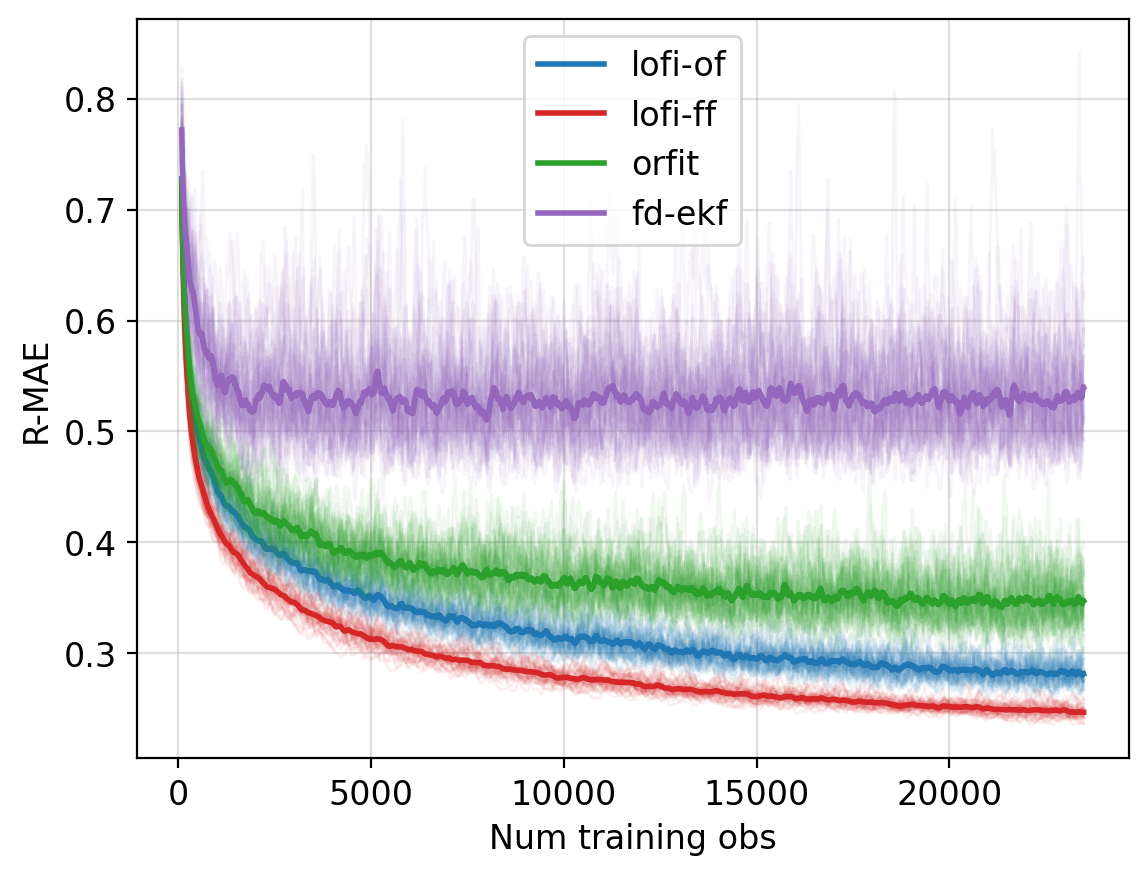

In [36]:
fig, ax = plt.subplots()

for label, data in collection.items():
    plot_sims(data, ax, colors[label], label)

plt.legend()
plt.grid(alpha=0.4)
plt.xlabel("Num training obs")
plt.ylabel("R-MAE")
plt.savefig(f"output/bounds-{dataset}.pdf")

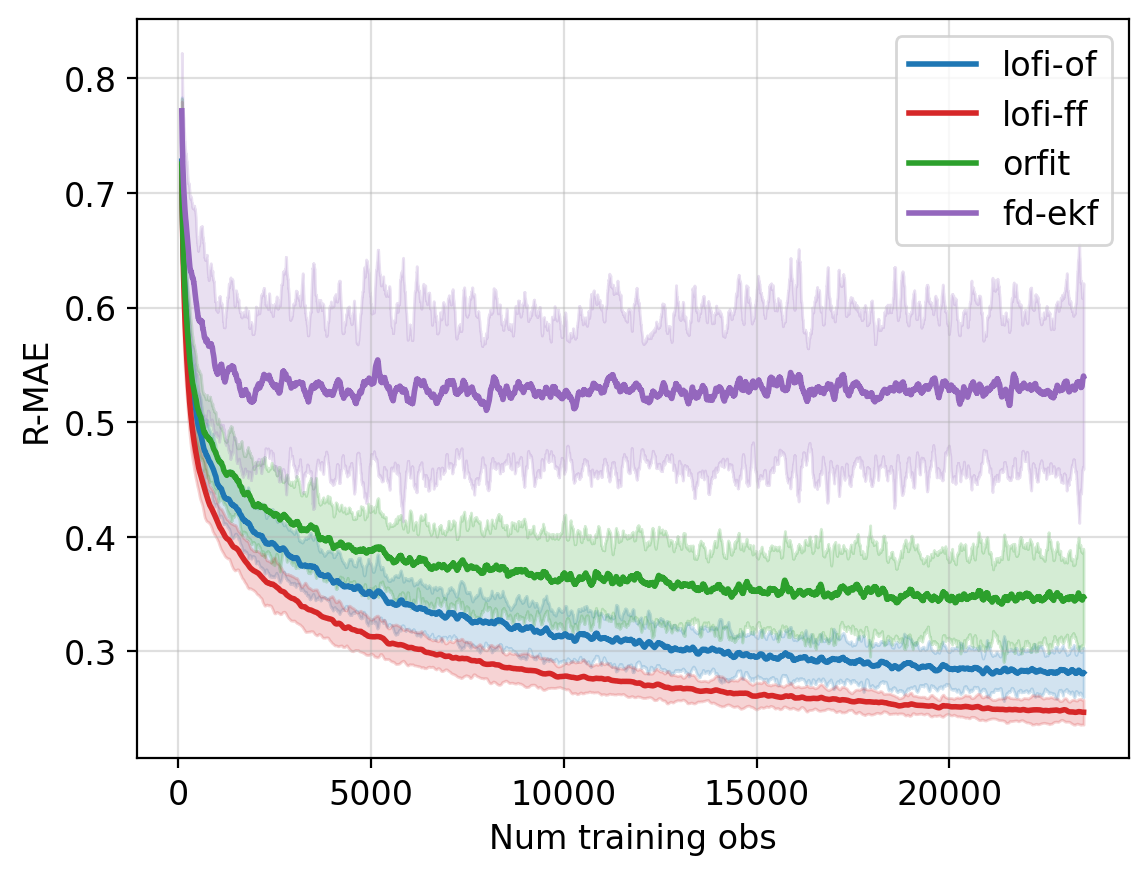

In [37]:
fig, ax = plt.subplots()

for label, data in collection.items():
    plot_bounds(data, ax, colors[label], label)

plt.legend()
plt.grid(alpha=0.4)
plt.xlabel("Num training obs")
plt.ylabel("R-MAE")
plt.savefig(f"output/sims-{dataset}.pdf")

In [38]:
last_rmae = {
    key: collection[key].iloc[-1]
    for key in collection
}
last_rmae = pd.DataFrame(last_rmae)

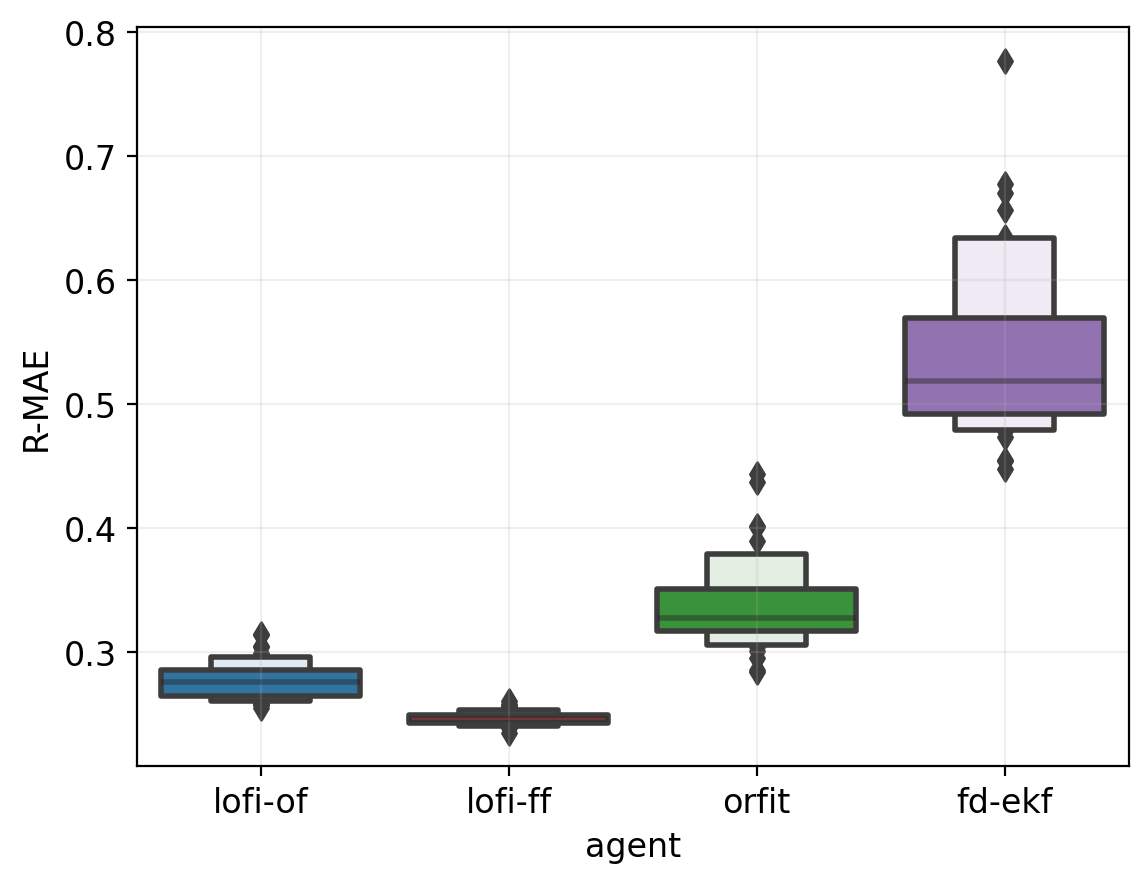

In [39]:
sns.boxenplot(
    x="agent",
    y="R-MAE",
    palette=colors,
    data=last_rmae.melt(var_name="agent", value_name="R-MAE")
)
plt.grid(alpha=0.2)
plt.savefig(f"output/last-metric-{dataset}.pdf")

### Plot rolling RMAE on the one-step-ahead posterior predictive

In [40]:
collection = {
    agent: pd.DataFrame(res["osa-error"]).T
    for agent, res in sims.items()
}

/tmp/ipykernel_4125575/1409588332.py:10: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f"output/one-step-ahead-sims-{dataset}.pdf")
/tmp/ipykernel_4125575/1409588332.py:10: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f"output/one-step-ahead-sims-{dataset}.pdf")
/home/gerardoduran/mambaforge/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


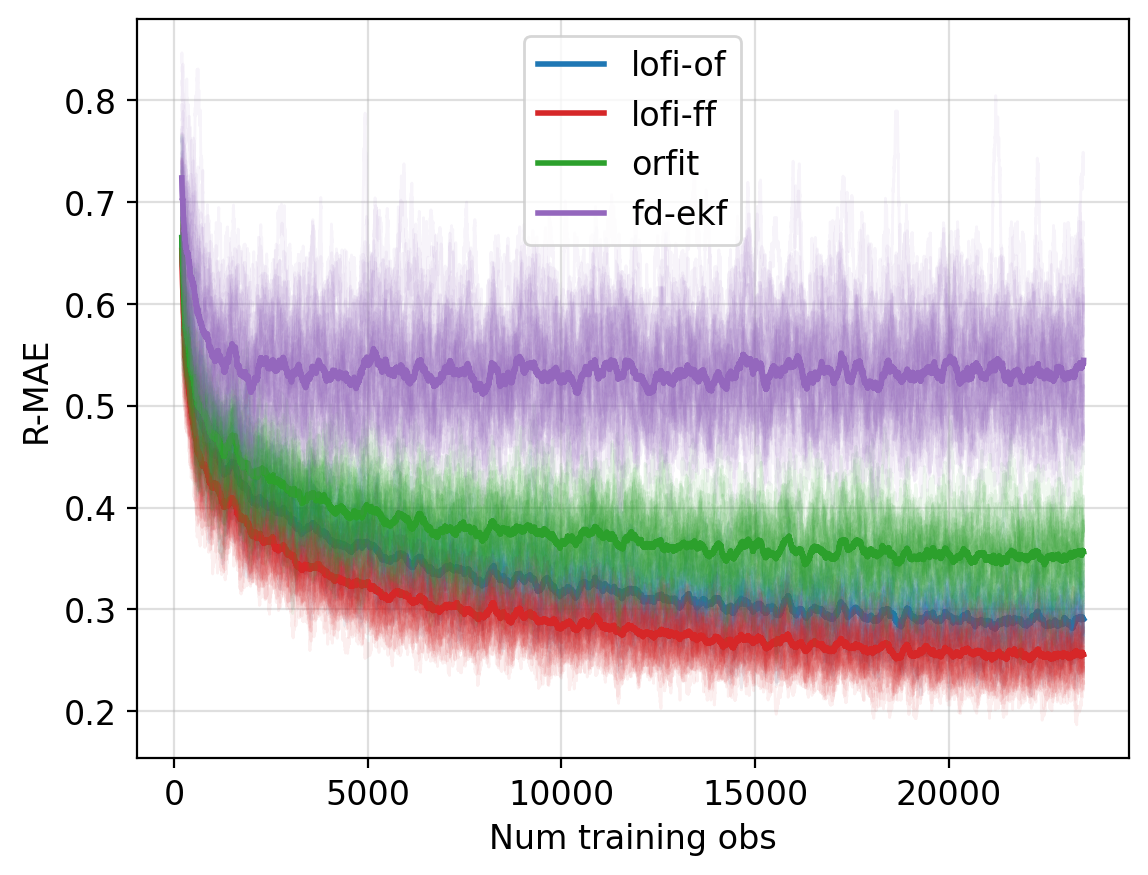

In [41]:
fig, ax = plt.subplots()

for label, data in collection.items():
    plot_sims(data, ax, colors[label], label, rolling=200)

plt.legend()
plt.grid(alpha=0.4)
plt.xlabel("Num training obs")
plt.ylabel("R-MAE")
plt.savefig(f"output/one-step-ahead-sims-{dataset}.pdf")

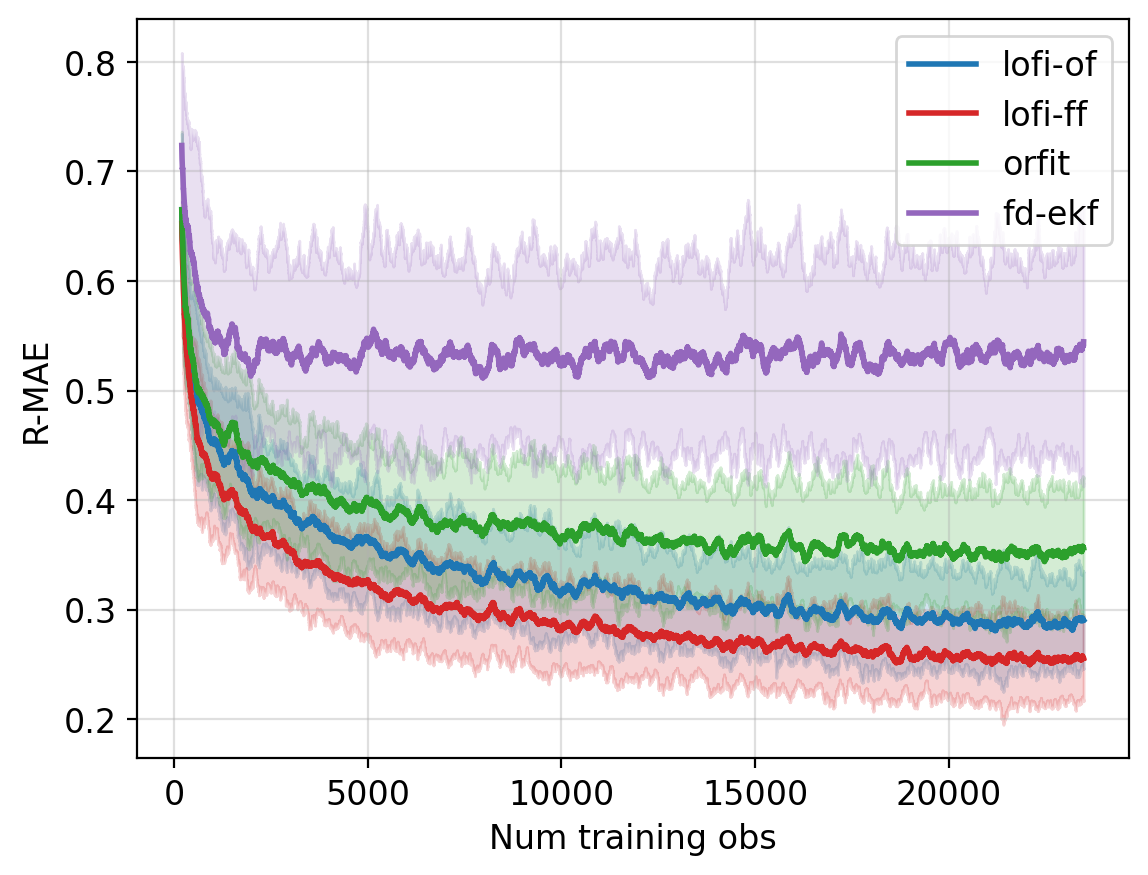

In [42]:
fig, ax = plt.subplots()

for label, data in collection.items():
    plot_bounds(data, ax, colors[label], label, rolling=200)

plt.legend()
plt.grid(alpha=0.4)
plt.xlabel("Num training obs")
plt.ylabel("R-MAE")
plt.savefig(f"output/one-step-ahead-bounds-{dataset}.pdf")